In [20]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/lukas/Code/active_sciencing/venv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [21]:
import gaussian
reload(gaussian)
import distr
import common
import emcee

In [24]:
PHI_RANGE     = [0,6]
THETA_RANGE   = [-2,2]
DATA_RANGE    = [-5,5] 
THE_SIMULATOR = gaussian.simulator

# Introducing the Model p(x|$\theta$,$\Phi$)

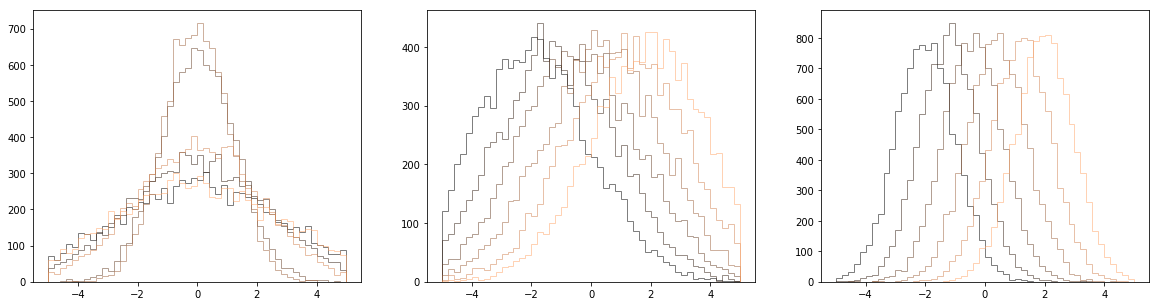

In [34]:
cm = plt.get_cmap('copper')
fig,axarr = plt.subplots(1,3)
fig.set_size_inches(20,5)
bins = np.linspace(*DATA_RANGE, num = 51)

nsteps_phi, theta_nom = 6, 0
for i,phi in enumerate(np.linspace(*PHI_RANGE,num = nsteps_phi)):
    _=axarr[0].hist(THE_SIMULATOR(theta_nom,phi,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')

nsteps_theta, phi_nom = 6, math.pi/2.
for i,theta in enumerate(np.linspace(*THETA_RANGE,num = nsteps_theta)):
    _=axarr[1].hist(THE_SIMULATOR(theta,phi_nom,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')
    
nsteps_theta, phi_nom = 6, math.pi
for i,theta in enumerate(np.linspace(*THETA_RANGE,num = nsteps_theta)):
    _=axarr[2].hist(THE_SIMULATOR(theta,phi_nom,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')

# An Example Experiment
## Taking Data

example_phi = math.pi/2.
example_theta = 1.
example_ndata = 1000


bins = np.linspace(*DATA_RANGE, num = 11)
example_data = common.collect_data(example_phi,THE_SIMULATOR, theta_nature=example_theta, n_samples = example_ndata)
datacounts,bins = np.histogram(example_data,bins = bins)
centers = bins[:-1] + (bins[1:]-bins[:-1])/2.
plt.errorbar(centers,datacounts,fmt = 'o',xerr = (bins[1:]-bins[:-1])/2.,yerr = np.sqrt(datacounts), c = 'k')

n_mc = 10000
mc = THE_SIMULATOR(example_theta,example_phi,n_mc) #simulate much more than data
mccounts,_,_ = plt.hist(mc,weights = [float(example_ndata)/float(n_mc)]*n_mc, bins = bins)


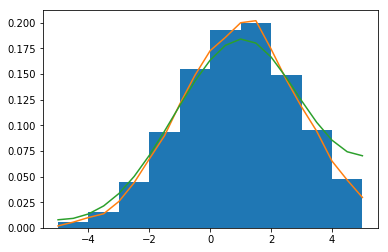

In [38]:
samples = THE_SIMULATOR(example_theta,example_phi,10000)
p = distr.Distribution(
    name = 'example_simulation',
    samples = samples,
    range = DATA_RANGE)

p.hist(bins = 10, normed = True)

xs = np.linspace(*DATA_RANGE,num = 21)
logpdf_nomirr = p.approx_logpdf()
logpdf_mirror = p.approx_logpdf(mirror = True, mirror_shifts=[-10,10])

plt.plot(xs,np.exp(logpdf_nomirr(xs)))
plt.plot(xs,np.exp(logpdf_mirror(xs)))

## The likelihood $p(x|\theta,\Phi)$ and the prior $p(\theta|\Phi)$

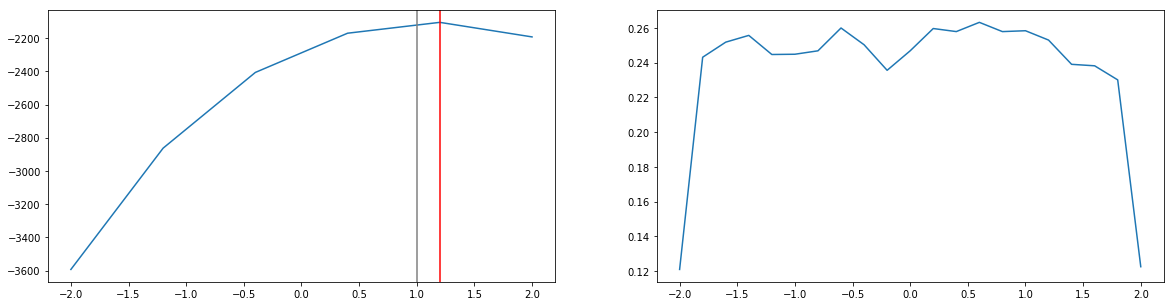

In [49]:
test_thetas = np.linspace(*THETA_RANGE,num = 6)

reload(common)
reload(weinberg)
reload(distr)
import multiprocessing
pool = multiprocessing.Pool(4)


nll = [pool.apply_async(common.lnlike,
                        args = (theta_test,example_data,example_phi),
                        kwds = dict(
                         simulator=THE_SIMULATOR,
                         simulation_kwargs = {'n_samples': 10000},
                         distr_kwargs =  {'range': DATA_RANGE},
                         logpdf_kwargs = {}
                        )
                       ) for theta_test in test_thetas]
[r.ready() for r in nll]

pool.close()
pool.join()
nll = [r.get() for r in nll]

fig,axarr = plt.subplots(1,2)

fig.set_size_inches(20,5)

axarr[0].plot(test_thetas,nll)
axarr[0].axvline(example_theta, c = 'grey') #truth
axarr[0].axvline(test_thetas[np.argmax(nll)], c = 'r') #max NLL


example_prior = distr.Distribution('prior',range = THETA_RANGE)
xs = np.linspace(*THETA_RANGE,num = 21)
logpdf = example_prior.approx_logpdf()
axarr[1].plot(xs,np.exp(logpdf(xs)))

## The posterior $p(\theta|x,\Phi)$

In [ ]:
import emcee
ndim, nwalkers = 1, 10
pos = [np.array([x]) for x in np.random.uniform(0.5,1.5,size=nwalkers)]
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, common.lnprob,
    args=(
        example_data,example_prior,example_phi,weinberg.simulator,
        dict(simulation_kwargs = {'n_samples': 10000},
             distr_kwargs =  {'range': DATA_RANGE},
             logpdf_kwargs = {'mirror': True, 'mirror_shifts': [-2,2]}
            )
        )
    )
_ = sampler.run_mcmc(pos, 50)